# Yelp Restaurant Image Classifier (Custom Model)
* Author: Peerapak Adsavakulchai
* Email: padsavak@uchicago.edu
* Purpose: University of Chicago MSCA 31009 Final Project

### Installation of Packages
Run if not already installed

In [1]:
!pip install tensorflow --quiet

In [2]:
!pip install -U efficientnet --quiet

In [3]:
!pip install keras-tuner --quiet

### Importing Packages and Dependencies

In [1]:
from google.cloud import storage
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras

from tensorflow.python.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

import keras_tuner as kt
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import RandomSearch


2023-05-10 20:09:30.707018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 20:09:31.846736: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-10 20:09:31.846855: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

### GCP Parameters

In [2]:
storage_client = storage.Client()
bucket_name = 'final-project-31009-peerapak-a'
bucket = storage_client.get_bucket(bucket_name)

### Data Processing

In [3]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)

In [4]:
#Setting up paths to image files

path_train = '/home/jupyter/Data/Train Data/'
path_test = '/home/jupyter/Data/Test Data/'


In [5]:
train_generator224 = train_datagen.flow_from_directory(
    path_train, 
    batch_size = 32, 
    class_mode = 'categorical', 
    target_size = (224, 224)
)


test_generator224 = test_datagen.flow_from_directory(
    path_test,  
    batch_size = 32, 
    class_mode = 'categorical', 
    target_size = (224, 224))


Found 1379 images belonging to 4 classes.
Found 589 images belonging to 4 classes.


In [6]:
train_generator224.image_shape

(224, 224, 3)

## Custom Model Training

* Different / customed convolutional hidden layers 
* Same dense layers as the 'best-in-class' models (for equivalent comparison)

* Introduces 1 layer of batch normalization since the model will be shallower

In [10]:
hp = HyperParameters()

In [12]:
def create_custom(hp):

    #Loading the base VGG16 Model  ----------------------------------
    base_model = tf.keras.Sequential()
    
    #1st convolutional layer
    base_model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = train_generator224.image_shape, padding = 'same'))
    #base_model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    base_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'))
    
    #2nd convolutional layer
    base_model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    #base_model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    base_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'))

    #3rd convolutional layer
    base_model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    #base_model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    base_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'))

    #4th convolutional layer
    base_model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    #base_model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    base_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'))
    
    #5th convolutional layer
    base_model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    #base_model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    base_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'))
    
    #6th convolutional layer
    base_model.add(tf.keras.layers.Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    #base_model.add(tf.keras.layers.Conv2D(filters = 512, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    base_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'))
    
    #7th convolutional layer
    base_model.add(tf.keras.layers.Conv2D(filters = 1024, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    #base_model.add(tf.keras.layers.Conv2D(filters = 1024, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    base_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'))
    
    '''
    #8th convolutional layer
    base_model.add(tf.keras.layers.Conv2D(filters = 2048, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    #base_model.add(tf.keras.layers.Conv2D(filters = 2048, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    base_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'))
    
    #9th convolutional layer
    base_model.add(tf.keras.layers.Conv2D(filters = 4096, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    #base_model.add(tf.keras.layers.Conv2D(filters = 4096, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    base_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'))
    
    #10th convolutional layer
    base_model.add(tf.keras.layers.Conv2D(filters = 8192, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    #base_model.add(tf.keras.layers.Conv2D(filters = 8192, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    base_model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = 'same'))
    '''
    
    #Recreating the Dense layers ----------------------------------

    #Dense Layer
    base_model.add(tf.keras.layers.GlobalAveragePooling2D())
    base_model.add(tf.keras.layers.Dense(512, activation='relu'))
    #Add Batch Normalization
    base_model.add(tf.keras.layers.BatchNormalization())
    # Add a dropout rate of 0.5
    base_model.add(tf.keras.layers.Dropout(0.5))
    base_model.add(tf.keras.layers.Dense(train_generator224.num_classes, activation = 'softmax'))
    
    
    model = base_model

#Hyper Parameters ------------------------------------------
    
    #hp = HyperParameters()
    lr = hp.Float('learning_rate', 1e-4, 1)
    loss = hp.Choice('loss', ['categorical_crossentropy', 'sparse_categorical_crossentropy'])
    opt = hp.Choice('optimizer', ['adam' ,'rmsprop', 'sgd'])
    
    if opt == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate = lr)
        
    elif opt == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate = lr)
        
    else:
        optimizer = keras.optimizers.SGD(learning_rate = lr)

   

    #Model Compiling -----------------------------------------
    
    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics=['accuracy'])
        
    return model
    

In [13]:
tuner = RandomSearch(create_custom,
                     objective = 'accuracy',
                     max_trials = 10,
                     executions_per_trial = 10,
                     directory = 'Custom_Training',
                     project_name = 'Custom_3')

In [14]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 5)

In [22]:
tuner.search(train_generator224, callbacks = [stop_early])

INFO:tensorflow:Oracle triggered exit


In [23]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters values
print(f'Best hyperparameters: {best_hps.values}')

Best hyperparameters: {'learning_rate': 0.10175386249991751, 'loss': 'categorical_crossentropy', 'optimizer': 'sgd'}


In [24]:
custom_best = tuner.hypermodel.build(best_hps)

In [25]:
custom_best.fit_generator(train_generator224, use_multiprocessing = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


44/44 [==============================] - 46s 999ms/step - loss: 1.1232 - accuracy: 0.5134


In [26]:
loss, accuracy = custom_best.evaluate_generator(test_generator224, use_multiprocessing = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [27]:
print('Custom Test loss:', loss)
print('Custom Test accuracy:', accuracy)

Custom Test loss: 1.0702494382858276
Custom Test accuracy: 0.5415959358215332


## Saving Best Performing Models for Later Use

In [29]:
path_model_save = '/home/jupyter/Best Model/'

In [30]:
custom_best.save(path_model_save + "custom.h5")

## Loading Models 
Use when reloading this worksheet after closing out GCP Instance

In [31]:
custom_load = tf.keras.models.load_model(path_model_save + "custom.h5")
                                                                 

## Predictions
* Predicting results from the model

In [33]:
true_class = test_generator224.classes

In [36]:
#Predictions from each model 

preds = custom_load.predict(test_generator224)


19/19 [==============================] - 8s 408ms/step


In [37]:
import numpy as np

predicted_classes = np.argmax(preds, axis=1)
prediction_probs = preds[np.arange(len(predicted_classes)), predicted_classes]


In [40]:
from sklearn.metrics import classification_report

print(classification_report(true_class, predicted_classes))
print(accuracy_score(true_class, predicted_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.54      1.00      0.70       319
           2       0.00      0.00      0.00       185
           3       0.00      0.00      0.00        28

    accuracy                           0.54       589
   macro avg       0.14      0.25      0.18       589
weighted avg       0.29      0.54      0.38       589

0.5415959252971138


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


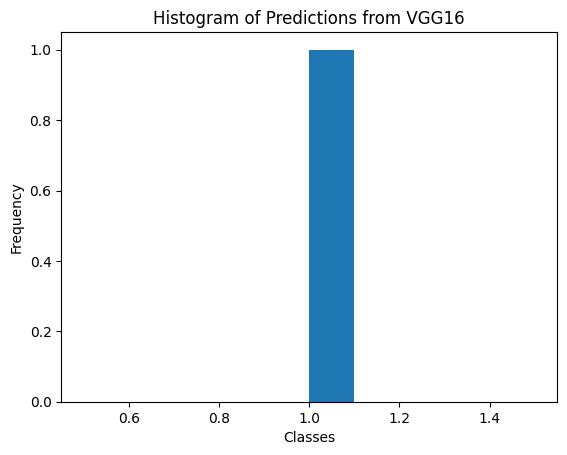

In [41]:
import matplotlib.pyplot as plt

plt.hist(predicted_classes[0])
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Histogram of Predictions from Custom Model')

# Show the plot
plt.show()

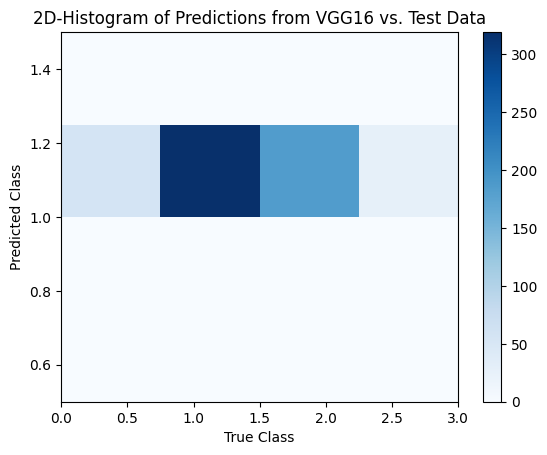

In [43]:
plt.hist2d(true_class, predicted_classes, bins=(4, 4), cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.title('2D-Histogram of Predictions from Custom Model vs. Test Data')
plt.show()